Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.


# Document preprocessing
Helper functions for preprocessing scanned documents prior to performing knowledge extraction using Forms Understanding or OCR. 

The included functionality:
- Descriptive statistics on scanned document
- Normalization
- Turn into grayscale
- Binarization


In [1]:
import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

from ipywidgets import interact, widgets,interactive, fixed, interact_manual
%matplotlib inline 

In [2]:
DATA_PATH = "../../Data/"

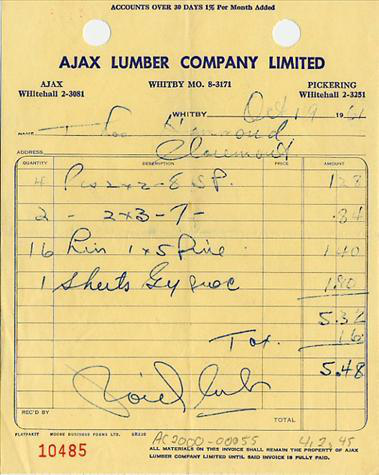

In [3]:
def load_image(img_file_path):
    """
    Loads an image from file into a PIL.Image object
    :param img_file_path: path to file
    :returns a PIL.image object with the loaded image
    """
    return Image.open(img_file_path)


filename = 'handwritten_invoice.jpg.scaled500.jpg'
img = load_image(Path(DATA_PATH,filename))
display(img)    

#### Image general information

In [4]:
x,y = img.size
print("Image size: ({}, {})".format(x,y))
print("Image mode: {}".format(img.mode))
print("Image format: {}".format(img.format))


Image size: (379, 475)
Image mode: RGB
Image format: JPEG


##### Histograms per image channel

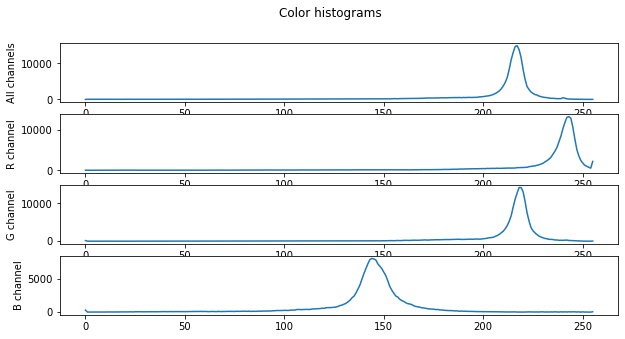

In [5]:
def plot_channel_histograms(img):
    """
    Plots histograms per channel and for a greyscale image
    """
    fig = plt.figure(figsize=(10,5))
    if img.mode == 'RGB':
        r, g, b = img.split() 
        
        fig.suptitle("Color histograms")

        plt.subplot(4, 1, 1)
        plt.plot(img.convert('L').histogram())
        plt.ylabel('All channels')

        plt.subplot(4, 1, 2)
        plt.plot(r.histogram())
        plt.ylabel('R channel')

        plt.subplot(4, 1, 3)
        plt.plot(g.histogram())
        plt.ylabel('G channel')

        plt.subplot(4, 1, 4)
        plt.plot(b.histogram())
        plt.ylabel('B channel')
        
    elif img.mode == '1':
        plt.plot(img.histogram())
        plt.ylabel('pixel value')
    else:
        raise ValueError("Unsupported image mode")

    plt.show()
plot_channel_histograms(img)

##### Descriptive statistics

In [6]:
from PIL.ImageStat import Stat
def stats_per_channel(img):
    stats = Stat(img)

    print("extrema: \n{}".format(stats.extrema))
    print("count: \n{}".format(stats.count))
    print("sum: \n{}".format(stats.extrema))
    print("squared sum: \n{}".format(stats.sum2))
    print("mean: \n{}".format(stats.mean))
    print("median: \n{}".format(stats.median))
    print("stddev: \n{}".format(stats.stddev))
    
stats_per_channel(img)


extrema: 
[(0, 255), (0, 255), (0, 255)]
count: 
[180025, 180025, 180025]
sum: 
[(0, 255), (0, 255), (0, 255)]
squared sum: 
[9618685669.0, 7916300995.0, 3746587530.0]
mean: 
[228.48084988196084, 207.14547979447298, 141.94911817803083]
median: 
[240, 217, 145]
stddev: 
[35.0174677564851, 32.62043476488972, 25.728049501709172]


##### Image normalization

In [7]:
from PIL import ImageOps

def normalize(img,cutoff=0):
    try:
        return ImageOps.autocontrast(img,cutoff=cutoff)
    except IOError:
        return img

#normalized = normalize(img,cutoff=1)
#plot_channel_histograms(normalized)


def make_normalization(img, figsize = (20,10),title=""):
    """
    Helper function for interactively plotting binarized image
    """
    def display_normalized_image(cutoff):
        """
        Plots a binarized image
        """
        plt.figure(figsize = figsize)
        plt.title(title)
        plt.imshow(normalize(img,cutoff))
    return display_normalized_image

def interactive_normalization(image, figsize = (20,10), title='Image normalization'):
    """
    Jupyter only method for interactively deciding on a threshold for image normalization
    """
    normalizer = make_normalization(image,figsize,title)
    step_slider = widgets.IntSlider(min=0, max=100, value=5)
    widgets.interact(normalizer, cutoff=step_slider)


In [8]:
interactive_normalization(img)

interactive(children=(IntSlider(value=5, description='cutoff'), Output()), _dom_classes=('widget-interact',))

##### Turn into grayscale

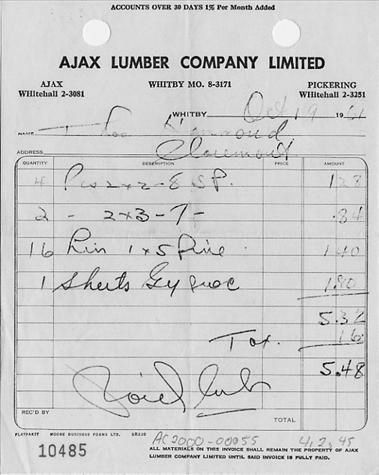

In [9]:
def to_grayscale(img):
    grayscale = img.convert('L')
    return grayscale

display(to_grayscale(img))

##### Image binarization

In [10]:
def binarize_image(img,threshold=100):
    """
    Turns an image into black and white only, using a given threshold
    """
    threshold_function = lambda x : 255 if x > threshold else 0
    return img.convert('L').point(threshold_function, mode='1')

def make_binarization(img, figsize = (20,10),title=""):
    """
    Helper function for interactively plotting binarized image
    """
    def display_binarized_image(threshold):
        """
        Plots a binarized image
        """
        plt.figure(figsize = figsize)
        plt.title(title)
        plt.imshow(binarize_image(img,threshold))
    return display_binarized_image

def interactive_binarization(image, figsize = (20,10), title='Image binarization'):
    """
    Jupyter only method for interactively deciding on a threshold for image binarization
    """
    binarizer = make_binarization(image,figsize,title)
    step_slider = widgets.IntSlider(min=0, max=255, value=100)
    widgets.interact(binarizer, threshold=step_slider)

In [11]:
interactive_binarization(img)

interactive(children=(IntSlider(value=100, description='threshold', max=255), Output()), _dom_classes=('widget…

#### Run normalization on all images in path

In [12]:
import os
from itertools import repeat
from types import FunctionType

valid_images = [".jpg",".gif",".png",".tga"]



def preprocess_images(path,*funcs):
    """
    Run a list of functions on each image in the provided path, and save a new manipulated image to the same path.
    """
    
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        raw = Image.open(os.path.join(path,f))
        preprocessed = raw
        for func in funcs:
            preprocessed = func(preprocessed)
        new_file="{}/preprocessed_{}".format(path,f)
        preprocessed.save(new_file)

                    

In [14]:
preprocess_images(Path(DATA_PATH),to_grayscale, normalize)